In [1]:
import os, sys, glob
import copy
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

sys.path.append('../src/')
from training import train_spotwise, train_gridwise
from count_datasets import load_count_dataset, load_count_grid_dataset, read_annotated_starray
from count_datasets import CountDataset, CountGridDataset
from gridnet_models import GridNetHexOddr
from utils import all_fgd_predictions
from hexagdly_tools import plot_hextensor
from plotting import performance_curves

(78, 64, 14) (78, 64)
['Layer1' 'Layer2' 'Layer3' 'Layer4' 'Layer5' 'Layer6' 'WM'] 0 7


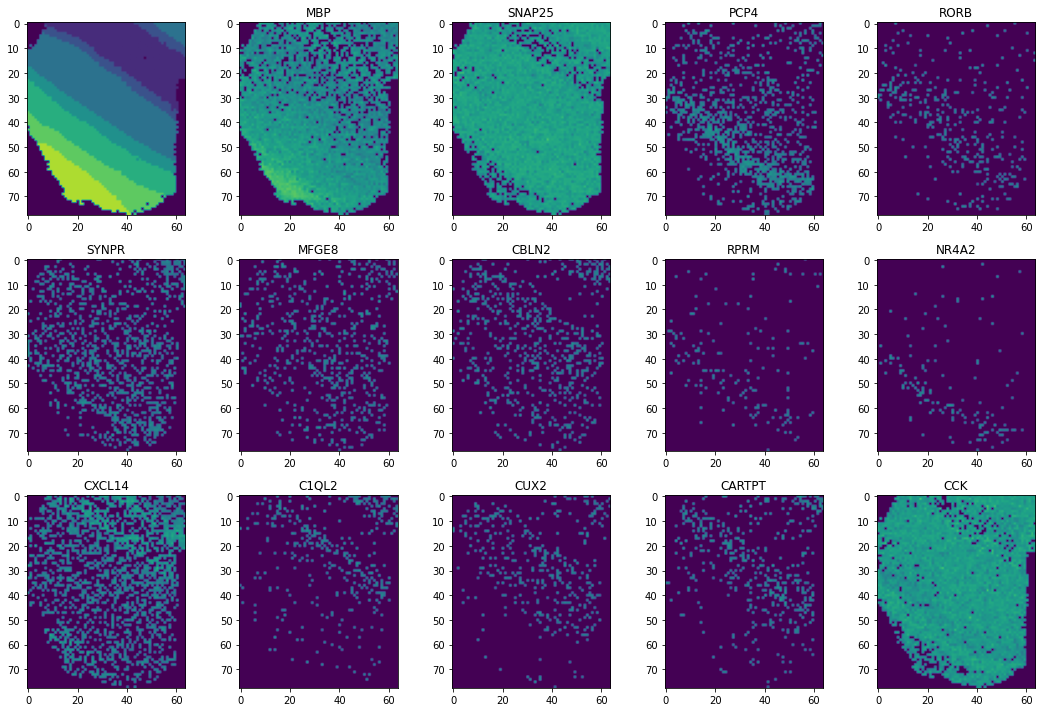

In [3]:
# Read in unified count files and associated annotations
# -> For now, we will use my pseudo-Splotch files as Maynard et al. provide neither Loupe-formatted annotations
#    nor key Spaceranger files (e.g., features, barcodes).

data_dir = os.path.expanduser('~/Documents/Splotch_projects/Maynard_DLPFC/data/')

# Count files have been depth-normalized, log-transformed, and scaled b/w 0 and 1
count_file = os.path.join(data_dir, 'Countfiles_Visium_norm', '151507_stdata_aligned_counts_IDs.txt.unified.tsv')
annot_file = os.path.join(data_dir, 'Covariates_Visium', '151507.tsv')

H_VISIUM = 78
W_VISIUM = 64

# Joana's manually curated list of layer marker genes:
jp_markers = {
    'MBP': 'ENSG00000197971',    # WM
    'SNAP25': 'ENSG00000132639', # GM (Layers 1-6)
    'PCP4': 'ENSG00000183036',   # Layer 5
    'RORB': 'ENSG00000198963',   # Layer 4
    'SYNPR': 'ENSG00000163630',  # Layer 6
    'MFGE8': 'ENSG00000140545',
    'CBLN2': 'ENSG00000141668',
    'RPRM': 'ENSG00000177519',
    'NR4A2': 'ENSG00000153234',
    'CXCL14': 'ENSG00000145824',
    'C1QL2': 'ENSG00000144119',
    'CUX2': 'ENSG00000111249',
    'CARTPT': 'ENSG00000164326',
    'CCK': 'ENSG00000187094'
}

counts_grid, annots_grid, gene_names, annot_names = read_annotated_starray(
    count_file, annot_file, select_genes = [x for _,x in jp_markers.items()])
print(counts_grid.shape, annots_grid.shape)
print(annot_names, annots_grid.min(), annots_grid.max())

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(3,5,1)
ax.imshow(annots_grid, vmin=0, vmax=len(annot_names)+1)

for i, (cname, ensmbl) in enumerate(jp_markers.items()):
    ax = fig.add_subplot(3,5,i+2)
    ax.imshow(counts_grid[:,:,np.where(gene_names==ensmbl)[0][0]], vmin=0, vmax=1)
    ax.set_title(cname)
    
plt.tight_layout()
plt.show()

Method 1: Registration using hand-selected marker genes

In [4]:
select_genes = [ensmbl for _, ensmbl in jp_markers.items()]

train_tissues = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674']
val_tissues = ['151675', '151676']

countfiles_train = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs.txt.unified.tsv') % s for s in train_tissues]
annotfiles_train = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % s for s in train_tissues]

countfiles_val = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs.txt.unified.tsv') % s for s in val_tissues]
annotfiles_val = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % s for s in val_tissues]

# Load full datasets into memory for quick training, since we have very few genes
train_spot_jp = load_count_dataset(countfiles_train, annotfiles_train, select_genes=select_genes)
val_spot_jp = load_count_dataset(countfiles_val, annotfiles_val, select_genes=select_genes)

dataloader_spot_jp = {
    'train': DataLoader(train_spot_jp, batch_size=128, shuffle=True),
    'val': DataLoader(val_spot_jp, batch_size=128)
}

Epoch 0/99
----------
train Loss: 1.5705 Acc: 0.4560
val Loss: 1.4165 Acc: 0.4949

Epoch 1/99
----------
train Loss: 1.3106 Acc: 0.5531
val Loss: 1.2825 Acc: 0.5294

Epoch 2/99
----------
train Loss: 1.2211 Acc: 0.5730
val Loss: 1.2089 Acc: 0.5570

Epoch 3/99
----------
train Loss: 1.1816 Acc: 0.5806
val Loss: 1.1822 Acc: 0.5608

Epoch 4/99
----------
train Loss: 1.1581 Acc: 0.5858
val Loss: 1.1584 Acc: 0.5667

Epoch 5/99
----------
train Loss: 1.1422 Acc: 0.5895
val Loss: 1.1481 Acc: 0.5685

Epoch 6/99
----------
train Loss: 1.1308 Acc: 0.5943
val Loss: 1.1208 Acc: 0.5761

Epoch 7/99
----------
train Loss: 1.1237 Acc: 0.5958
val Loss: 1.1326 Acc: 0.5735

Epoch 8/99
----------
train Loss: 1.1163 Acc: 0.5971
val Loss: 1.1111 Acc: 0.5841

Epoch 9/99
----------
train Loss: 1.1127 Acc: 0.5984
val Loss: 1.1094 Acc: 0.5788

Epoch 10/99
----------
train Loss: 1.1089 Acc: 0.5986
val Loss: 1.1119 Acc: 0.5785

Epoch 11/99
----------
train Loss: 1.1041 Acc: 0.6009
val Loss: 1.1067 Acc: 0.5804

Ep


Epoch 98/99
----------
train Loss: 1.0506 Acc: 0.6157
val Loss: 1.1153 Acc: 0.5847

Epoch 99/99
----------
train Loss: 1.0502 Acc: 0.6132
val Loss: 1.1168 Acc: 0.5762

Training complete in 1m 27s
Best val Acc: 0.593826


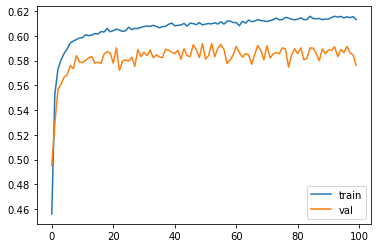

In [7]:
spot_clf_jp = nn.Sequential(
    nn.Linear(len(select_genes), 50),
    nn.Linear(50, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    
    nn.Linear(100, 100),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    
    nn.Linear(50, len(annot_names))
)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(spot_clf_jp.parameters(), lr=1e-4)

spot_clf_jp, val_hist, train_hist = train_spotwise(spot_clf_jp, dataloader_spot_jp, loss, optimizer, 100, display=False,
                                      outfile='../models/spot_classifier_markers_jp.pth')

fig = plt.figure()
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.legend()

In [8]:
train_grid_jp = load_count_grid_dataset(countfiles_train, annotfiles_train, select_genes=select_genes)
val_grid_jp = load_count_grid_dataset(countfiles_val, annotfiles_val, select_genes=select_genes)

dataloader_grid_jp = {
    'train': DataLoader(train_grid_jp, batch_size=1, shuffle=True),
    'val': DataLoader(val_grid_jp, batch_size=1, shuffle=False)
}

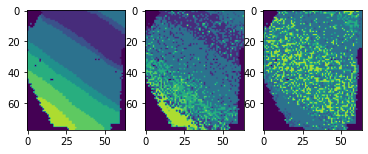

In [11]:
# Now try in a GridNet setting
x, y = next(iter(dataloader_grid_jp['train']))

gnet_jp = GridNetHexOddr(spot_clf_jp, (len(select_genes),), (H_VISIUM, W_VISIUM), n_classes=len(annot_names),
                 use_bn=False)
gnet_jp.eval()
out_g = gnet_jp(x)
out_p = gnet_jp.patch_predictions(x)

pred_g = out_g[0].data.argmax(0) + 1
pred_g[y[0]==0] = 0  # Zero-out BG spots

pred_p = out_p[0].data.argmax(0) + 1
pred_p[y[0]==0] = 0  # Zero-out BG spots

fig, ax = plt.subplots(1,3)
ax[0].imshow(y[0].data, vmin=0, vmax=len(annot_names)+1)
ax[1].imshow(pred_p, vmin=0, vmax=len(annot_names)+1)
ax[2].imshow(pred_g, vmin=0, vmax=len(annot_names)+1)

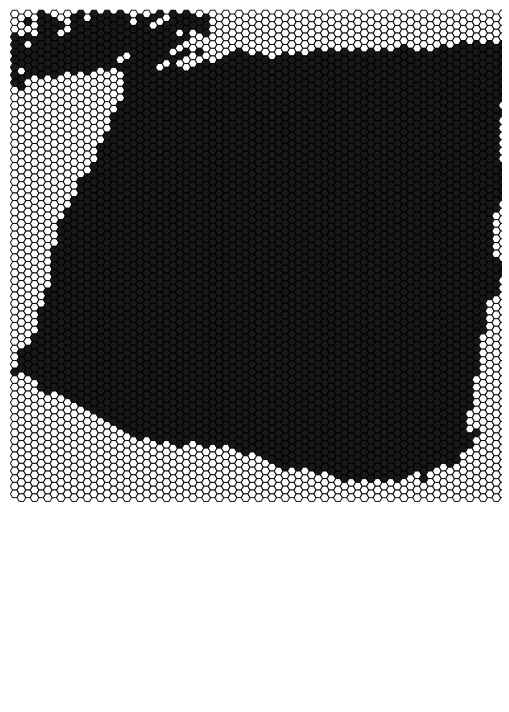

In [12]:
# Demonstrate that we can preserve adjacency by transforming between Visium and HexagDLy indexing schemes.
_, y = val_grid_jp[0]

y = torch.rot90(y, 1, [1,0]) # Rotate 90 CW
y = torch.flip(y, [1])       # Flip horizontally

test_input = torch.tensor(np.zeros((1,1,64,78)))
test_input[0, 0, y>0] = 1

plot_hextensor(test_input)

Epoch 0/99
----------
train Loss: 18.4919 Acc: 0.4154
val Loss: 9.9681 Acc: 0.4811

Epoch 1/99
----------
train Loss: 7.8719 Acc: 0.4540
val Loss: 6.5502 Acc: 0.4955

Epoch 2/99
----------
train Loss: 4.8329 Acc: 0.4932
val Loss: 3.9319 Acc: 0.5284

Epoch 3/99
----------
train Loss: 3.2711 Acc: 0.4972
val Loss: 2.8246 Acc: 0.5377

Epoch 4/99
----------
train Loss: 2.4152 Acc: 0.5274
val Loss: 2.5545 Acc: 0.5334

Epoch 5/99
----------
train Loss: 1.9424 Acc: 0.5308
val Loss: 2.0059 Acc: 0.5518

Epoch 6/99
----------
train Loss: 1.7013 Acc: 0.5839
val Loss: 1.7555 Acc: 0.5484

Epoch 7/99
----------
train Loss: 1.6260 Acc: 0.4763
val Loss: 1.6822 Acc: 0.5094

Epoch 8/99
----------
train Loss: 1.4275 Acc: 0.5599
val Loss: 1.4538 Acc: 0.6018

Epoch 9/99
----------
train Loss: 1.3001 Acc: 0.6163
val Loss: 1.3813 Acc: 0.5920

Epoch 10/99
----------
train Loss: 1.2173 Acc: 0.6474
val Loss: 1.3359 Acc: 0.6356

Epoch 11/99
----------
train Loss: 1.1122 Acc: 0.6724
val Loss: 1.2075 Acc: 0.6263

E

val Loss: 0.7819 Acc: 0.7193

Epoch 98/99
----------
train Loss: 0.4048 Acc: 0.8331
val Loss: 0.7439 Acc: 0.7272

Epoch 99/99
----------
train Loss: 0.4004 Acc: 0.8362
val Loss: 0.7497 Acc: 0.7259

Training complete in 0m 49s
Best val Acc: 0.750464


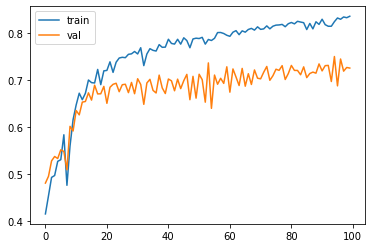

In [13]:
gnet_jp = GridNetHexOddr(spot_clf_jp, (len(select_genes),), (H_VISIUM, W_VISIUM), n_classes=len(annot_names),
                 use_bn=False)

# Fixing the parameters of the patch classifier allows slightly faster training, even when only
#   optimizing the parameters of the corrector. 
for param in gnet_jp.patch_classifier.parameters():
    param.requires_grad = False

loss = nn.CrossEntropyLoss()

# Only optimize the parameters in the g-network
optimizer = torch.optim.Adam(gnet_jp.corrector.parameters(), lr=1e-3)

gnet_jp, val_hist, train_hist = train_gridwise(gnet_jp, dataloader_grid_jp, loss, optimizer, num_epochs=100,
                                  outfile='../models/gnet_markers_jp.opt')

fig = plt.figure()
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.legend()

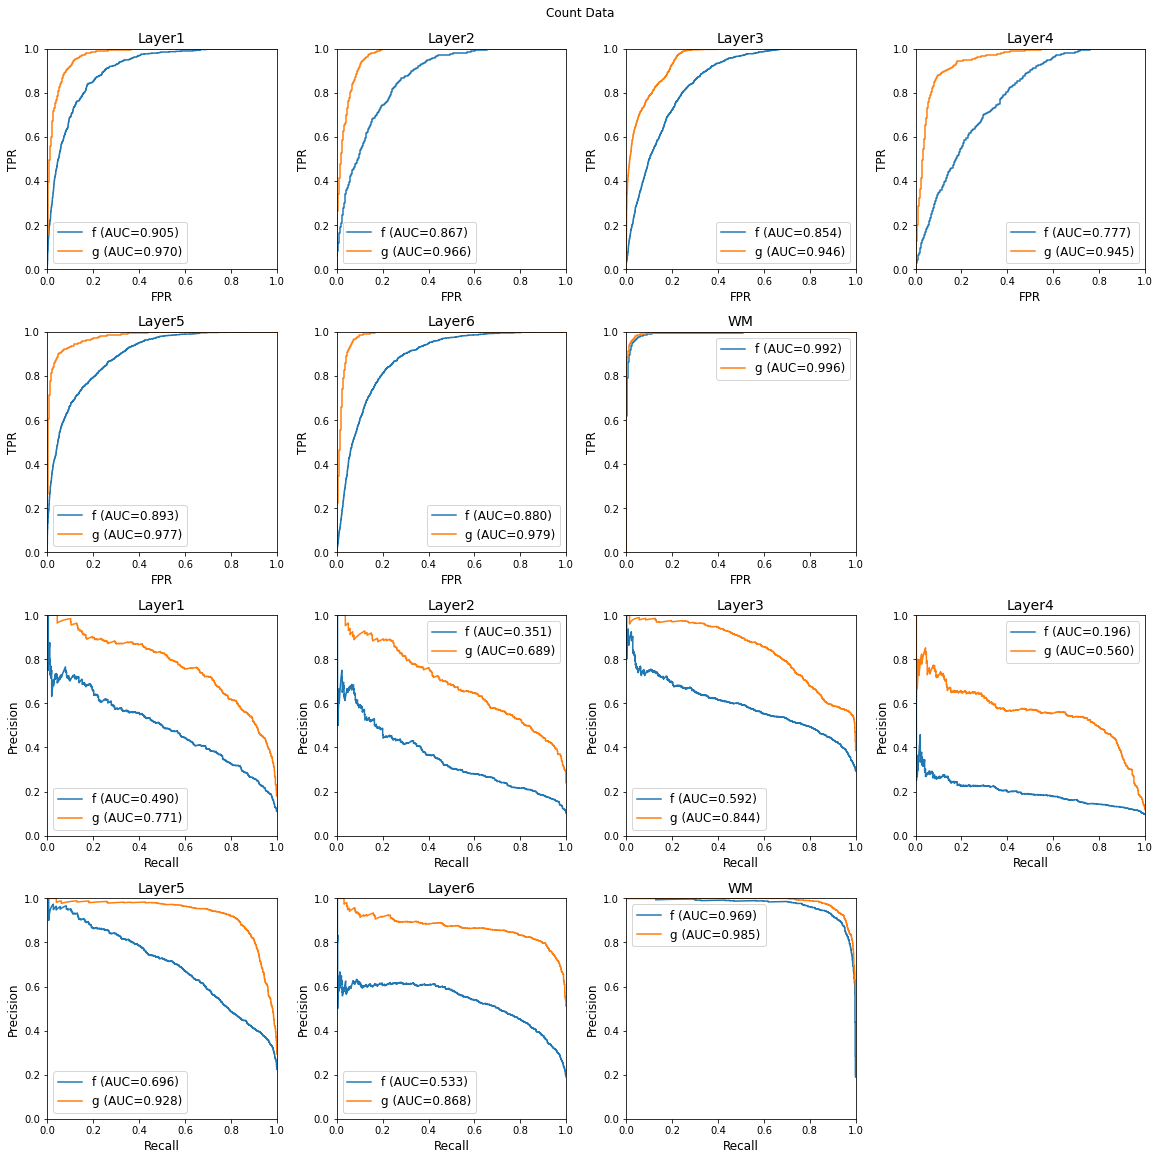

f predictions - count data
ACC: 0.594, MACRO_AUROC: 0.881, MACRO_AUPRC: 0.547
g predictions - count data
ACC: 0.750, MACRO_AUROC: 0.969, MACRO_AUPRC: 0.806


In [15]:
true_vals, patch_preds, patch_smax = all_fgd_predictions(dataloader_grid_jp['val'], gnet_jp, f_only=True)
_, grid_preds, grid_smax = all_fgd_predictions(dataloader_grid_jp['val'], gnet_jp)

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [patch_smax, grid_smax], annot_names, ['f','g'])
fig.suptitle('Count Data')
plt.savefig('../outputs/performance_curves_count.png', dpi=300, format='PNG')
plt.show()

acc = np.sum(patch_preds == true_vals) / len(true_vals)

print('f predictions - count data')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[0], macro_auprc[0]))

acc = np.sum(grid_preds == true_vals) / len(true_vals)

print('g predictions - count data')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[1], macro_auprc[1]))

True


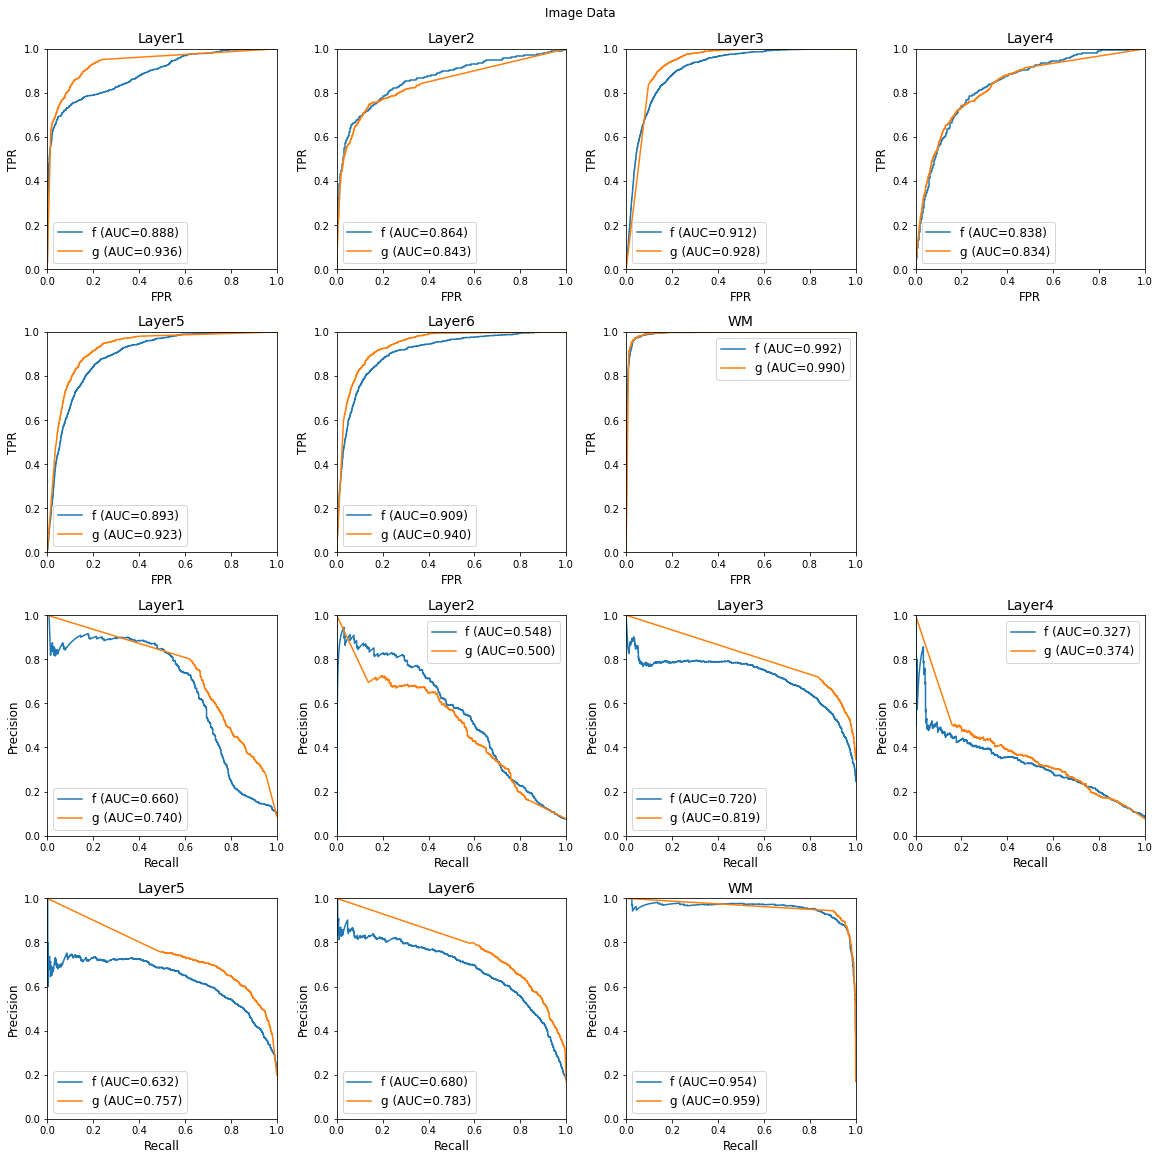

f predictions - image data
ACC: 0.669, MACRO_AUROC: 0.899, MACRO_AUPRC: 0.646
g predictions - image data
ACC: 0.716, MACRO_AUROC: 0.913, MACRO_AUPRC: 0.705


In [16]:
# See how we stack up against predictions made using image data
true_vals_img = np.load('../outputs/maynard_imgpred_fgd/maynard_true_6fold_5_oddr.npy')
print(np.array_equal(true_vals, true_vals_img))  # Make sure we've flattened in a consistent order


# Predictions using f network only:
patch_smax_img = np.load('../outputs/maynard_imgpred_fgd/maynard_smax_f_6fold_5_oddr.npy')

# Predictions using g network:
grid_smax_img = np.load('../outputs/maynard_imgpred_fgd/maynard_smax_g_6fold_5_oddr.npy')

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [patch_smax_img, grid_smax_img], annot_names, ['f','g'])
fig.suptitle('Image Data')
plt.savefig('../outputs/performance_curves_image.png', dpi=300, format='PNG')
plt.show()

patch_pred_img = np.argmax(patch_smax_img, axis=1)
acc = np.sum(true_vals == patch_pred_img) / len(true_vals)

print('f predictions - image data')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[0], macro_auprc[0]))

grid_pred_img = np.argmax(grid_smax_img, axis=1)
acc = np.sum(true_vals == grid_pred_img) / len(true_vals)

print('g predictions - image data')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[1], macro_auprc[1]))

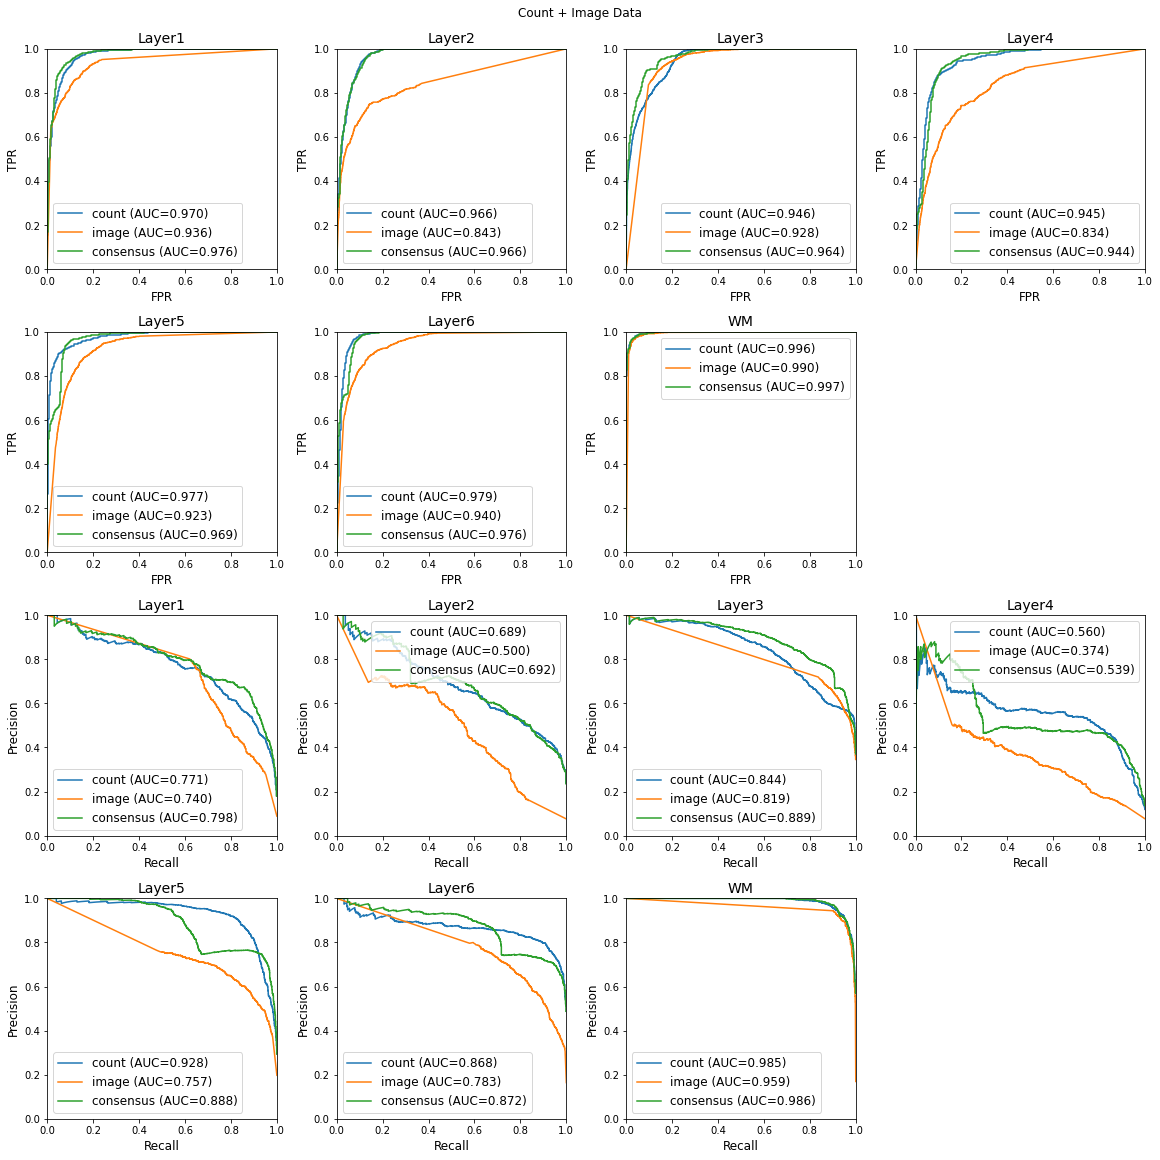

g predictions (consensus) - count + image data
ACC: 0.730, MACRO_AUROC: 0.970, MACRO_AUPRC: 0.809


In [17]:
# Now create an ensemble classifier using both count and image data:
consensus_smax = np.array((grid_smax, grid_smax_img)).mean(axis=0)

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [grid_smax, grid_smax_img, consensus_smax], 
                                                       annot_names, ['count', 'image', 'consensus'])
fig.suptitle('Count + Image Data')
plt.savefig('../outputs/performance_curves_consensus.png', dpi=300, format='PNG')
plt.show()

consensus_pred = np.argmax(consensus_smax, axis=1)
acc = np.sum(consensus_pred == true_vals) / len(true_vals)

print('g predictions (consensus) - count + image data')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[2], macro_auprc[2]))